### Imports

In [1]:
# Data Preprocessing
import polars as pl  # Polars for efficient data manipulation
import numpy as np  # NumPy for numerical operations
from pandas_datareader.data import DataReader  # DataReader for fetching financial data from online sources
from ta.volume import VolumeWeightedAveragePrice  # TA-Lib for technical analysis, such as VWAP
import warnings

# Suppress specific warnings related to deprecated distutils
warnings.filterwarnings("ignore", category=DeprecationWarning, module="pandas_datareader")

# Environment
import gym  # Gym is used for creating reinforcement learning environments, useful for developing trading strategies
from gym import spaces  # Spaces are used to define action and observation spaces in Gym
import random  # Random is used for generating random numbers, useful in simulations

# PyTorch
import os  # OS is used for interacting with the operating system
import torch as T  # PyTorch for building and training neural networks
import torch.nn as nn  # nn is used for creating neural network layers
import torch.optim as optim  # Optim is used for optimization algorithms
from torch.distributions.categorical import Categorical  # Categorical is used for categorical distributions, useful in RL

# Outputs
import matplotlib.pyplot as plt  # Matplotlib for visualizing trading data and results


### Data Preprocessing

In [2]:
import yfinance as yf  # yfinance for fetching financial data

# Data Extraction parameters
start_date = "2017-01-01"  # Start date for historical data
end_date = "2022-06-01"    # End date for historical data
symbol = "AAPL"            # Ticker symbol for the stock (Apple Inc. in this case)

# Fetch data using yfinance
df_yf = yf.download(symbol, start=start_date, end=end_date)

# Convert to Polars DataFrame
df = pl.from_pandas(df_yf.reset_index())

# Ensure 'Date' column is in the correct timezone
df = df.with_columns(pl.col('Date').dt.replace_time_zone('America/New_York'))

# Drop the 'Adj Close' column as it's not needed for our analysis
df = df.drop('Adj Close')

# Display the first two rows of the Polars DataFrame
print(df.head(2))


[*********************100%%**********************]  1 of 1 completed
shape: (2, 6)
┌────────────────────────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ Date                           ┆ Open      ┆ High      ┆ Low       ┆ Close     ┆ Volume    │
│ ---                            ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ datetime[ns, America/New_York] ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ i64       │
╞════════════════════════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2017-01-03 00:00:00 EST        ┆ 28.950001 ┆ 29.0825   ┆ 28.690001 ┆ 29.0375   ┆ 115127600 │
│ 2017-01-04 00:00:00 EST        ┆ 28.9625   ┆ 29.127501 ┆ 28.9375   ┆ 29.004999 ┆ 84472400  │
└────────────────────────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/base.py:279: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  endDt = pd.to_datetime(_datetime.datetime.utcfromtimestamp(end))


In [3]:
import polars as pl

def calculate_vwap(df: pl.DataFrame, window_size: int = 14) -> pl.DataFrame:
    """
    Calculate the Volume Weighted Average Price (VWAP) for a given DataFrame.
    
    Args:
    df (pl.DataFrame): Input DataFrame with 'High', 'Low', 'Close', and 'Volume' columns.
    window_size (int): The rolling window size for VWAP calculation.
    
    Returns:
    pl.DataFrame: DataFrame with added VWAP column.
    """
    df = df.with_columns([
        (((pl.col("High") + pl.col("Low") + pl.col("Close")) / 3 * pl.col("Volume")).rolling_sum(window_size) / 
         pl.col("Volume").rolling_sum(window_size)).alias("VWAP")
    ])
    
    return df

# Apply VWAP calculation
df = calculate_vwap(df)

# Drop rows with NaN values
df = df.drop_nulls()

# Display the first two rows of the updated DataFrame
print(df.head(2))

# # Optional: Calculate VWAP Crossover signals
# df = df.with_columns([
#     (pl.col("Close") > pl.col("VWAP")).alias("Above_VWAP"),
#     (pl.col("Close").shift(1) <= pl.col("VWAP").shift(1) & 
#      pl.col("Close") > pl.col("VWAP")).alias("VWAP_Crossover_Up"),
#     (pl.col("Close").shift(1) >= pl.col("VWAP").shift(1) & 
#      pl.col("Close") < pl.col("VWAP")).alias("VWAP_Crossover_Down")
# ])

# print(df.head(2))

shape: (2, 7)
┌─────────────────────────┬───────────┬───────────┬───────────┬─────────┬──────────┬───────────┐
│ Date                    ┆ Open      ┆ High      ┆ Low       ┆ Close   ┆ Volume   ┆ VWAP      │
│ ---                     ┆ ---       ┆ ---       ┆ ---       ┆ ---     ┆ ---      ┆ ---       │
│ datetime[ns,            ┆ f64       ┆ f64       ┆ f64       ┆ f64     ┆ i64      ┆ f64       │
│ America/New_York]       ┆           ┆           ┆           ┆         ┆          ┆           │
╞═════════════════════════╪═══════════╪═══════════╪═══════════╪═════════╪══════════╪═══════════╡
│ 2017-01-23 00:00:00 EST ┆ 30.0      ┆ 30.202499 ┆ 29.942499 ┆ 30.02   ┆ 88200800 ┆ 29.66347  │
│ 2017-01-24 00:00:00 EST ┆ 29.887501 ┆ 30.025    ┆ 29.875    ┆ 29.9925 ┆ 92844000 ┆ 29.737769 │
└─────────────────────────┴───────────┴───────────┴───────────┴─────────┴──────────┴───────────┘


In [4]:
import polars as pl

def preprocess_trading_data(df: pl.DataFrame) -> pl.DataFrame:
    """
    Preprocess trading data: calculate percentage changes, scale, and prepare for analysis.
    
    Args:
    df (pl.DataFrame): Input DataFrame with trading data.
    
    Returns:
    pl.DataFrame: Preprocessed DataFrame ready for analysis or model input.
    """
    # List of columns to process
    cols_to_process = ['High', 'Low', 'Open', 'Close', 'Volume', 'VWAP']
    
    # Calculate percentage change
    df_pct = df.select([
        (pl.col(col).pct_change()).alias(col)
        for col in cols_to_process if col in df.columns
    ])
    
    # Scale by dividing by max value (not absolute max)
    df_scaled = df_pct.select([
        (pl.col(col) / pl.col(col).max()).alias(col)
        for col in df_pct.columns
    ])
    
    # Add Close_Price from original DataFrame
    df_scaled = df_scaled.with_columns([
        df['Close'].alias('Close_Price')
    ])
    
    # Drop first row (NaN from pct_change) and reset index
    df_scaled = df_scaled.slice(1).with_row_index()  # Using with_row_index instead of with_row_count
    
    return df_scaled

# Apply preprocessing
df_preprocessed = preprocess_trading_data(df)

# Display the first few rows of the preprocessed DataFrame
print(df_preprocessed.head())



shape: (5, 8)
┌───────┬───────────┬───────────┬───────────┬───────────┬───────────┬──────────┬─────────────┐
│ index ┆ High      ┆ Low       ┆ Open      ┆ Close     ┆ Volume    ┆ VWAP     ┆ Close_Price │
│ ---   ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---      ┆ ---         │
│ u32   ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64      ┆ f64         │
╞═══════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪══════════╪═════════════╡
│ 0     ┆ -0.055937 ┆ -0.022097 ┆ -0.038558 ┆ -0.007646 ┆ 0.020029  ┆ 0.132253 ┆ 29.9925     │
│ 1     ┆ 0.1585    ┆ 0.063981  ┆ 0.074826  ┆ 0.132884  ┆ 0.150258  ┆ 0.161017 ┆ 30.469999   │
│ 2     ┆ 0.026504  ┆ 0.107573  ┆ 0.106732  ┆ 0.004109  ┆ -0.070977 ┆ 0.152441 ┆ 30.485001   │
│ 3     ┆ -0.006996 ┆ 0.0       ┆ 0.039719  ┆ 0.000684  ┆ -0.083421 ┆ 0.134313 ┆ 30.487499   │
│ 4     ┆ -0.056011 ┆ -0.075773 ┆ -0.101862 ┆ -0.021902 ┆ 0.181599  ┆ 0.093867 ┆ 30.407499   │
└───────┴───────────┴───────────┴───

#### Why preprocessing for Neural Networks in trading:

1. Normalization: By scaling the data (dividing by max), we ensure all features are on a similar scale.
   This is crucial for neural networks as it helps prevent certain features from dominating others
   solely due to their scale, allowing the model to learn appropriate weights for each feature.

2. Percentage Changes: Using percentage changes instead of absolute values helps capture relative
   movements in the market. This makes the model more robust to overall market trends and allows
   it to focus on patterns in price movements rather than absolute price levels.

3. Preserving Original Close Price: Keeping the original closing prices allows the model to relate
   percentage changes back to actual price levels, which can be crucial for making trading decisions
   and calculating potential profits or losses.

4. Time Series Nature: By using percentage changes from the previous day, we maintain the time series
   nature of the data. This is important for many trading strategies that rely on sequential patterns.

5. Feature Consistency: Preprocessing ensures that all features (High, Low, Open, Close, Volume, VWAP)
   are treated consistently, which helps the neural network to learn meaningful relationships between
   these features.

6. Handling Different Scales: Different stocks may trade at very different price levels. By using
   percentage changes and scaling, we make it possible for a single model to work effectively across
   multiple stocks or even asset classes.

7. Outlier Management: Scaling by the maximum value helps to manage outliers without removing them
   entirely, preserving important information about significant market moves.

This preprocessing approach helps create a robust input for neural networks in trading applications,
allowing the model to focus on learning meaningful patterns in price movements and relationships
between different market indicators.

In [5]:
df_mod = df_preprocessed.drop('Date')
df_mod = df_mod.fill_null(0)
df_mod.head()

index,High,Low,Open,Close,Volume,VWAP,Close_Price
i64,f64,f64,f64,f64,f64,f64,f64
0,-0.055937,-0.022097,-0.038558,-0.007646,0.020029,0.132253,29.9925
1,0.1585,0.063981,0.074826,0.132884,0.150258,0.161017,30.469999
2,0.026504,0.107573,0.106732,0.004109,-0.070977,0.152441,30.485001
3,-0.006996,0.0,0.039719,0.000684,-0.083421,0.134313,30.487499
4,-0.056011,-0.075773,-0.101862,-0.021902,0.181599,0.093867,30.407499


### Training and Testing

In [6]:
import polars as pl

def split_trading_data(df: pl.DataFrame, split_index: int) -> tuple[pl.DataFrame, pl.DataFrame]:
    """
    Split the trading data into training and testing sets.
    
    Args:
    df (pl.DataFrame): Input DataFrame with preprocessed trading data.
    split_index (int): The index at which to split the data.
    
    Returns:
    tuple[pl.DataFrame, pl.DataFrame]: Training and testing DataFrames.
    """
    df_train = df.slice(0, split_index)
    df_test = df.slice(split_index)
    return df_train, df_test

# Define the split index
split_index = 700

# Split the DataFrame into training and testing sets
df_train, df_test = split_trading_data(df_mod, split_index)

# Display the first few rows of the training set
print("Training Set:")
print(df_train.head())

# Display the first few rows of the testing set
print("\nTesting Set:")
print(df_test.head())


Training Set:
shape: (5, 8)
┌───────┬───────────┬───────────┬───────────┬───────────┬───────────┬──────────┬─────────────┐
│ index ┆ High      ┆ Low       ┆ Open      ┆ Close     ┆ Volume    ┆ VWAP     ┆ Close_Price │
│ ---   ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---      ┆ ---         │
│ i64   ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64      ┆ f64         │
╞═══════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪══════════╪═════════════╡
│ 0     ┆ -0.055937 ┆ -0.022097 ┆ -0.038558 ┆ -0.007646 ┆ 0.020029  ┆ 0.132253 ┆ 29.9925     │
│ 1     ┆ 0.1585    ┆ 0.063981  ┆ 0.074826  ┆ 0.132884  ┆ 0.150258  ┆ 0.161017 ┆ 30.469999   │
│ 2     ┆ 0.026504  ┆ 0.107573  ┆ 0.106732  ┆ 0.004109  ┆ -0.070977 ┆ 0.152441 ┆ 30.485001   │
│ 3     ┆ -0.006996 ┆ 0.0       ┆ 0.039719  ┆ 0.000684  ┆ -0.083421 ┆ 0.134313 ┆ 30.487499   │
│ 4     ┆ -0.056011 ┆ -0.075773 ┆ -0.101862 ┆ -0.021902 ┆ 0.181599  ┆ 0.093867 ┆ 30.407499   │
└───────┴───────────┴─

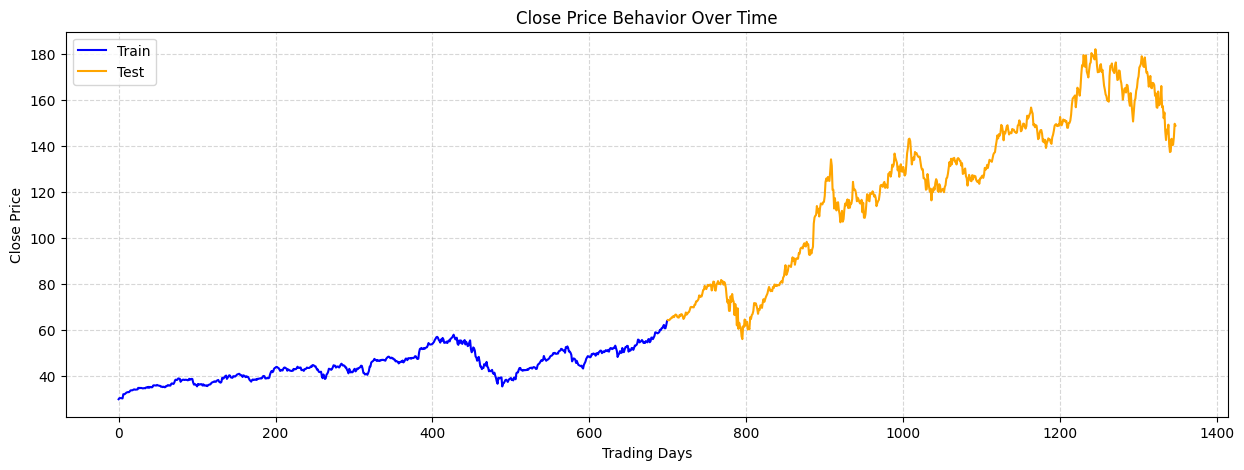

In [7]:
import matplotlib.pyplot as plt
import polars as pl

def visualize_price_behavior(df_train: pl.DataFrame, df_test: pl.DataFrame):
    """
    Visualize the price behavior of training and testing datasets.

    Args:
    df_train (pl.DataFrame): Training dataset
    df_test (pl.DataFrame): Testing dataset
    """
    # Set the figure size
    plt.figure(figsize=(15, 5))

    # Plot the Close_Price for the training set
    plt.plot(df_train["index"], df_train["Close_Price"], label='Train', color='blue')

    # Plot the Close_Price for the testing set
    plt.plot(df_test["index"], df_test["Close_Price"], label='Test', color='orange')

    # Add labels and legend
    plt.title("Close Price Behavior Over Time")
    plt.xlabel("Trading Days")
    plt.ylabel("Close Price")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    # Show the plot
    plt.show()

# Call the function to visualize price behavior
visualize_price_behavior(df_train, df_test)



### Enviornment

In [8]:
# Initialize variables
MAX_INT = 2147483647
MAX_TRADES = 10000
MAX_OPEN_POSITIONS = 1
INITIAL_ACCOUNT_BALANCE = 1000
PERCENT_CAPITAL = 0.1
TRADING_COSTS_RATE = 0.001
KILL_THRESH = 0.4  # Threshold for balance preservation

class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df: pl.DataFrame):
        super(StockTradingEnv, self).__init__()
        
        # Generic variables
        self.df = df
        
        # Account variables
        self.available_balance = INITIAL_ACCOUNT_BALANCE
        self.net_profit = 0
        
        # Position variables
        self.num_trades_long = 0
        self.num_trades_short = 0
        self.long_short_ratio = 0
        
        # Current Step
        self.current_step = 0
        self.lag = 20
        self.volatility = 1
        self.max_steps = len(df)

        # Actions of the format Long, Short
        self.action_space = spaces.Discrete(2)

        # Prices contains the OHLCV and VWAP data
        self.observation_space = spaces.Box(low=-1, high=1, shape=(7,), dtype=np.float32)

    def _calculate_reward(self):
        reward = 0
        reward += self.net_profit / self.volatility
        reward += 0.01 if self.long_short_ratio >= 0.3 and self.long_short_ratio <= 0.6 else -0.01
        return reward
        
    def _next_observation(self):
            # Get the current row of data
            current_data = self.df.slice(self.current_step, 1)
            
            # Extract individual items
            item_0_T0 = current_data["Open"].item()
            item_1_T0 = current_data["High"].item()
            item_2_T0 = current_data["Low"].item()
            item_3_T0 = current_data["Close"].item()
            item_4_T0 = current_data["Volume"].item()
            item_5_T0 = current_data["VWAP"].item()
            
            # Calculate env_4 based on long_short_ratio
            env_4 = 1 if self.long_short_ratio else 0
            
            # Create the observation array
            obs = np.array([item_0_T0, item_1_T0, item_2_T0, item_3_T0, item_4_T0, item_5_T0, env_4])
            
            return obs

    def _take_action(self, action):
        # Get current and next price
        current_price = self.df["Close_Price"].slice(self.current_step, 1).item()
        next_price = self.df["Close_Price"].slice(self.current_step + 1, 1).item()
        next_return = next_price / current_price - 1
        
        # Go Long
        if action == 0:
            self.net_profit += self.available_balance * PERCENT_CAPITAL * next_return
            self.available_balance += self.net_profit
            self.num_trades_long += 1
                
        # Go Short
        if action == 1:
            self.net_profit += self.available_balance * PERCENT_CAPITAL * -next_return
            self.available_balance += self.net_profit
            self.num_trades_short += 1
        
        # Update metrics
        self.long_short_ratio = self.num_trades_long / (self.num_trades_long + self.num_trades_short)
        self.volatility = self.df["Close_Price"].slice(self.current_step - self.lag, self.lag).sum()

    def step(self, action):
        # Execute the action
        self._take_action(action)
    
        # Calculate the reward for this step
        reward = self._calculate_reward()
    
        # Move to the next step
        self.current_step += 1
        
        # Check if the episode is done
        is_max_steps_taken = self.current_step >= self.max_steps - self.lag - 1
        done = True if is_max_steps_taken else False
        
        # Get the next observation
        obs = self._next_observation()
    
        # Return the step information
        return obs, reward, done, {}

    def reset(self):
        self.available_balance = INITIAL_ACCOUNT_BALANCE
        self.net_profit = 0
        self.current_step = self.lag
        self.num_trades_long = 0
        self.num_trades_short = 0
        self.long_short_ratio = 0

        return self._next_observation()

    def render(self, mode='human', close=False):
        pass



In [9]:
# Test Environment
env = StockTradingEnv(df_train)  # Initialize the environment with the training data
actions = [0, 1, 2]  # Define possible actions: 0 for Hold, 1 for Buy, 2 for Sell

# Reset the environment to the initial state
observation = env.reset()
print("Initial Observation: ", observation)

# Iterate over predefined actions
for action in actions:
    obs_, reward, done, info = env.step(action)  # Take a step in the environment with the action
    
    # Print results for each action
    print("")
    print("Action Taken: ", action)
    print("Reward Received: ", reward)
    print("Next State: ", obs_)
    print("Completed: ", done)
    print("-------------------")
    print("Available Balance: ", env.available_balance)
    print("Net Profit: ", env.net_profit)
    print("-------------------")
    
    if done:
        print("End of Episode")
        break

# Final state of the environment
print("\nFinal State:")
print("Available Balance: ", env.available_balance)
print("Net Profit: ", env.net_profit)

Initial Observation:  [ 0.01509509  0.02575197  0.00937149  0.02503413 -0.0569813   0.46506052
  0.        ]

Action Taken:  0
Reward Received:  -0.010654557676747507
Next State:  [ 7.15985945e-02  2.49887330e-02  1.36833751e-02 -3.53080268e-02
 -8.89242817e-04  2.47030709e-01  1.00000000e+00]
Completed:  False
-------------------
Available Balance:  999.5769806516864
Net Profit:  -0.42301934831360244
-------------------

Action Taken:  1
Reward Received:  0.00920344657816141
Next State:  [-0.11002195 -0.05676909 -0.07335508  0.00794776  0.01809007  0.19031721
  1.        ]
Completed:  False
-------------------
Available Balance:  999.0587808379853
Net Profit:  -0.5181998137011128
-------------------

Action Taken:  2
Reward Received:  0.009207905933640398
Next State:  [ 0.09305449  0.05432432  0.07245869  0.01648989 -0.02654296  0.18722969
  1.        ]
Completed:  False
-------------------
Available Balance:  999.0587808379853
Net Profit:  -0.5181998137011128
-------------------

Fin

### Memory

In [10]:
import numpy as np

class PPOMemory:
    def __init__(self, batch_size):
        # Initialize lists to store experience data
        self.states = []   # Store states experienced by the agent
        self.probs = []    # Store action probabilities (for importance sampling in PPO)
        self.vals = []     # Store value function estimates
        self.actions = []  # Store actions taken by the agent
        self.rewards = []  # Store rewards received
        self.dones = []    # Store done flags indicating episode completion
        
        self.batch_size = batch_size  # Set the batch size for training

    def generate_batches(self):
        # Get the total number of stored experiences
        n_states = len(self.states)
        
        # Create start indices for each batch
        batch_start = np.arange(0, n_states, self.batch_size)
        
        # Create an array of indices and shuffle it for randomized batches
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        
        # Create batches by slicing shuffled indices
        batches = [indices[i:i+self.batch_size] for i in batch_start]
        
        # Return the stored data as numpy arrays along with the batches
        return (np.array(self.states),
                np.array(self.actions),
                np.array(self.probs),
                np.array(self.vals),
                np.array(self.rewards),
                np.array(self.dones),
                batches)

    def store_memory(self, state, action, probs, vals, reward, done):
        # Append each element to the respective list
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        # Clear all stored data, preparing for the next episode or iteration
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

### Additional comments on PPO context:
"""
PPO (Proximal Policy Optimization) is an on-policy algorithm that requires
recent experience for training. This memory class facilitates:

1. Experience Collection: Stores state, action, reward, and other relevant 
   information as the agent interacts with the environment.

2. Importance Sampling: Stores action probabilities (self.probs) which are 
   crucial for computing the importance sampling ratio in PPO.

3. Batch Processing: Enables efficient training by organizing experiences 
   into batches, allowing for stochastic gradient descent updates.

4. On-Policy Learning: The clear_memory method ensures that only recent 
   experiences are used, maintaining the on-policy nature of PPO.

This memory structure is particularly suited for PPO because it allows for:
- Easy computation of advantages (using rewards and value estimates)
- Calculation of the PPO clipped objective
- Efficient policy and value function updates

When using this with PPO, remember to clear the memory after each update
to ensure you're always training on the most recent policy's data.
"""

### Actor and Critic

In [11]:
import os
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
                 fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/'):
        super(ActorNetwork, self).__init__()
        
        # Define the checkpoint file path for saving and loading the model
        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        
        # Ensure the checkpoint directory exists
        os.makedirs(chkpt_dir, exist_ok=True)
        
        # Define the architecture of the actor network
        self.actor = nn.Sequential(
            nn.Linear(*input_dims, fc1_dims),  # Input layer
            nn.ReLU(),  # Activation function
            nn.Linear(fc1_dims, fc2_dims),  # Hidden layer 1
            nn.ReLU(),  # Activation function
            nn.Linear(fc2_dims, n_actions),  # Output layer
            nn.Softmax(dim=-1)  # Softmax to convert outputs to probabilities
        )
        
        # Define the optimizer for the network
        self.optimizer = optim.AdamW(self.parameters(), lr=alpha)
        
        # Determine the device for computations (GPU if available, otherwise CPU)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)  # Move the model to the chosen device

    def forward(self, state):
        # Forward pass through the network to get action probabilities
        action_probs = self.actor(state)
        dist = Categorical(action_probs)  # Convert the output to a categorical distribution
        
        return dist

    def save_checkpoint(self):
        # Save the model's parameters to the checkpoint file
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        # Load the model's parameters from the checkpoint file
        self.load_state_dict(T.load(self.checkpoint_file))

#### Additional comments on the Actor's role in PPO:
"""
The ActorNetwork in PPO serves several crucial functions:

1. Policy Representation: It represents the current policy π(a|s) that maps
   states to a probability distribution over actions.

2. Exploration: By outputting a probability distribution, it allows for 
   exploration in the action space.

3. Policy Gradient Computation: During training, its parameters are updated
   to maximize the PPO objective, which involves the policy gradient.

4. Importance Sampling: The action probabilities it outputs are used to 
   compute importance sampling ratios in the PPO algorithm.

5. Adaptability: As a neural network, it can adapt to complex state spaces,
   making it suitable for the stock trading environment.

In the context of stock trading:
- The input (state) might include features like current price, volume, 
  technical indicators, etc.
- The output (action probabilities) would correspond to trading decisions 
  like buy, sell, or hold.

The use of a categorical distribution assumes discrete actions, which aligns
with many trading strategies. For continuous action spaces (e.g., deciding 
the exact amount to trade), you might need to modify this to output a 
different kind of distribution (like a Gaussian).
"""

### Critic

In [12]:
import os
import torch as T
import torch.nn as nn
import torch.optim as optim

class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/'):
        super(CriticNetwork, self).__init__()
        
        # Define the checkpoint file path for saving and loading the model
        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        
        # Ensure the checkpoint directory exists
        os.makedirs(chkpt_dir, exist_ok=True)
        
        # Define the architecture of the critic network
        self.critic = nn.Sequential(
            nn.Linear(*input_dims, fc1_dims),  # Input layer
            nn.ReLU(),  # Activation function
            nn.Linear(fc1_dims, fc2_dims),  # Hidden layer 1
            nn.ReLU(),  # Activation function
            nn.Linear(fc2_dims, 1)  # Output layer producing a single value
        )
        
        # Define the optimizer for the network
        self.optimizer = optim.AdamW(self.parameters(), lr=alpha)
        
        # Determine the device for computations (GPU if available, otherwise CPU)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)  # Move the model to the chosen device

    def forward(self, state):
        # Forward pass through the network to get the value estimate
        value = self.critic(state)
        return value

    def save_checkpoint(self):
        # Save the model's parameters to the checkpoint file
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        # Load the model's parameters from the checkpoint file
        self.load_state_dict(T.load(self.checkpoint_file))

# Additional comments on the Critic's role in PPO for stock trading:
"""
The CriticNetwork in PPO serves several crucial functions, particularly in a stock trading context:

1. Value Estimation: It estimates the value function V(s), which represents the expected
   return from being in a particular state. In stock trading, this could be interpreted
   as the expected future profit from the current market state.

2. Advantage Calculation: The critic's estimates are used to compute the advantage function,
   which is crucial for the PPO update. The advantage tells us how much better an action
   is compared to the average action in that state.

3. Risk Assessment: In stock trading, the critic's value estimates can be seen as a form
   of risk assessment. Higher value estimates might indicate more promising market conditions.

4. Baseline for Policy Improvement: The critic's estimates serve as a baseline in the
   policy gradient calculation, helping to reduce variance in the updates.

5. Market Trend Identification: Over time, the critic might learn to identify valuable
   market states or trends that lead to higher returns.

In the context of stock trading:
- The input (state) might include features like current price, volume, technical indicators,
  market indices, or even macroeconomic data.
- The output (value) represents the expected future returns from the current market state,
  which can guide trading decisions.

The use of a neural network allows the critic to capture complex, non-linear relationships
in the market data, potentially identifying subtle patterns that can inform trading strategies.
"""

### Agent

In [13]:
import numpy as np
import torch as T

class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
                 policy_clip=0.2, batch_size=64, n_epochs=10):
        # Hyperparameters
        self.gamma = gamma  # Discount factor for future rewards
        self.policy_clip = policy_clip  # Clipping parameter for PPO
        self.n_epochs = n_epochs  # Number of epochs to train on each batch of data
        self.gae_lambda = gae_lambda  # Lambda parameter for Generalized Advantage Estimation

        # Initialize actor and critic networks
        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        # Store experience in memory
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        # Convert observation to tensor and move to device
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        state = state.flatten(0)

        # Get action distribution and value estimate
        dist = self.actor(state)
        value = self.critic(state)
        
        # Sample action and get its log probability
        action = dist.sample()
        probs = T.squeeze(dist.log_prob(action)).item()
        
        # Convert to scalar values
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            # Generate batches from stored experiences
            state_arr, action_arr, old_prob_arr, vals_arr, \
            reward_arr, dones_arr, batches = self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)
            
            # Calculate advantage using Generalized Advantage Estimation (GAE)
            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)

            values = T.tensor(values).to(self.actor.device)
            
            # Iterate over batches for training
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                # Get new action distributions and value estimates
                dist = self.actor(states)
                critic_value = self.critic(states)
                critic_value = T.squeeze(critic_value)

                # Calculate probability ratio for PPO
                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                
                # Calculate PPO losses
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                # Compute total loss and perform backpropagation
                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        # Clear memory after learning
        self.memory.clear_memory()



#### Additional comments on PPO in stock trading context:
"""
This PPO agent is well-suited for stock trading for several reasons:

1. Risk-Adjusted Decision Making: The advantage calculation considers both 
   immediate rewards and future value estimates, helping the agent make 
   decisions that balance short-term gains with long-term strategy.

2. Stability in Learning: PPO's clipped objective prevents too large policy 
   updates, which is crucial in the volatile stock market to avoid overreacting 
   to market fluctuations.

3. Exploration vs Exploitation: The stochastic policy (sampling from a 
   distribution) allows for exploration of different trading strategies while 
   still exploiting known profitable actions.

4. Adaptability: The neural network architecture allows the agent to adapt to 
   changing market conditions and learn complex patterns in stock data.

5. Sample Efficiency: PPO is generally more sample efficient than many other 
   RL algorithms, which is beneficial when training on historical stock data.

When using this agent for stock trading:
- Ensure the reward function in the environment properly reflects trading 
  objectives (e.g., risk-adjusted returns).
- Consider using a wide range of features in the state space, including 
  technical indicators, fundamental data, and even market sentiment indicators.
- Regularly evaluate the agent's performance on out-of-sample data to ensure 
  it's not overfitting to historical patterns.
- Be cautious of the agent's limitations - while it can learn complex strategies, 
  it doesn't have the contextual understanding of global events or company-specific 
  news that can significantly impact stock prices.
"""

### Testing

In [14]:
import numpy as np

# Initialize the stock trading environment with training data
env = StockTradingEnv(df_train)

# Define hyperparameters for the PPO agent
batch_size = 5  # Number of experiences to collect before learning
n_epochs = 4    # Number of times to iterate over each batch during learning
alpha = 0.0003  # Learning rate for the neural networks

# Initialize the PPO agent
agent = Agent(n_actions=env.action_space.n, 
              batch_size=batch_size, 
              alpha=alpha, 
              n_epochs=n_epochs, 
              input_dims=env.observation_space.shape)

# Reset the environment to get the initial market state
observation = env.reset()

# Agent decides on an action based on the current market state
action, prob, val = agent.choose_action(observation)

# Print initial details
n_actions = env.action_space.n
print("Initial Market State (Observation):", observation)
print("Number of Possible Trading Actions:", n_actions)
print("Chosen Trading Action:", action)
print("Probability of Chosen Action:", prob)
print("Estimated Value of Current State:", val)

# Execute the chosen trading action in the environment
next_observation, reward, done, info = env.step(action)

# Print the results of the trading action
print("\nResults of Trading Action:")
print("Next Market State:", next_observation)
print("Reward (e.g., profit/loss):", reward)
print("Trading Episode Complete:", done)
print("Additional Info:", info)

# Additional analysis
print("\nAdditional Analysis:")
print("Change in Market State:")
state_change = next_observation - observation
for i, change in enumerate(state_change):
    print(f"Feature {i}: {change:.4f}")

print("\nAction Confidence:")
action_confidence = np.exp(prob)  # Convert log probability to actual probability
print(f"Confidence in chosen action: {action_confidence:.4f}")

print("\nValue Estimate Comparison:")
print(f"Estimated value before action: {val:.4f}")
print(f"Actual reward received: {reward:.4f}")
print(f"Difference: {reward - val:.4f}")

# Trading performance metrics (assuming these are tracked in the environment)
print("\nTrading Performance Metrics:")
print(f"Current Portfolio Value: ${env.net_worth:.2f}")
print(f"Total Profit/Loss: ${env.total_profit:.2f}")
print(f"Number of Trades: {env.total_trades}")



Initial Market State (Observation): [ 0.01509509  0.02575197  0.00937149  0.02503413 -0.0569813   0.46506052
  0.        ]
Number of Possible Trading Actions: 2
Chosen Trading Action: 0
Probability of Chosen Action: -0.692025363445282
Estimated Value of Current State: -0.05177207663655281

Results of Trading Action:
Next Market State: [ 7.15985945e-02  2.49887330e-02  1.36833751e-02 -3.53080268e-02
 -8.89242817e-04  2.47030709e-01  1.00000000e+00]
Reward (e.g., profit/loss): -0.010654557676747507
Trading Episode Complete: False
Additional Info: {}

Additional Analysis:
Change in Market State:
Feature 0: 0.0565
Feature 1: -0.0008
Feature 2: 0.0043
Feature 3: -0.0603
Feature 4: 0.0561
Feature 5: -0.2180
Feature 6: 1.0000

Action Confidence:
Confidence in chosen action: 0.5006

Value Estimate Comparison:
Estimated value before action: -0.0518
Actual reward received: -0.0107
Difference: 0.0411

Trading Performance Metrics:


/var/folders/4w/6x3yk1r13xvcwchd72ftlnsc0000gn/T/ipykernel_45562/2482824811.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  state = T.tensor([observation], dtype=T.float).to(self.actor.device)


AttributeError: 'StockTradingEnv' object has no attribute 'net_worth'

"""
Interpretation Guide:

1. Market State (Observation): This represents the current market conditions,
   including factors like price, volume, and potentially technical indicators.

2. Trading Action: 
   - 0 might represent 'Hold'
   - 1 might represent 'Buy'
   - 2 might represent 'Sell'
   (The exact mapping depends on how you've defined actions in your environment)

3. Action Probability: Higher probabilities indicate more confidence in the chosen action.

4. State Value: This is the agent's estimate of future returns from the current state.
   A higher value suggests the agent believes the current market state is favorable.

5. Reward: This represents the immediate outcome of the action, often in terms of
   profit or loss. Note that in trading, pursuing only immediate rewards can be risky.

6. Done Flag: If True, it means the trading episode has ended. This could be due to
   reaching a time limit, bankruptcy, or achieving a profit target.

7. State Change: This shows how each feature of the market state has changed after
   the action. Large changes might indicate significant market movements.

8. Action Confidence: This gives a clearer picture of how certain the agent was about
   its action. Values closer to 1 indicate higher confidence.

9. Value Estimate vs Actual Reward: A large difference here might indicate that the
   agent's understanding of the market state's value needs improvement.

10. Trading Metrics: These give an overview of the agent's performance in terms of
    portfolio value, profit/loss, and trading frequency.

Remember, this is just one step in the trading process. In a full training loop,
you would repeat this process many times, allowing the agent to learn and improve
its trading strategy over time.
"""

### Learning

... starting ...
... saving models ...
episode: 0, score: -64.08, avg score: -64.08, best score: -64.08, learning steps: 32
... saving models ...
episode: 1, score: 8.08, avg score: -28.00, best score: -28.00, learning steps: 65
... saving models ...
episode: 2, score: 18.65, avg score: -12.45, best score: -12.45, learning steps: 98
... saving models ...
episode: 3, score: 48.78, avg score: 2.86, best score: 2.86, learning steps: 131
episode: 4, score: -12.63, avg score: -0.24, best score: 2.86, learning steps: 164
episode: 5, score: -10.33, avg score: -1.92, best score: 2.86, learning steps: 197
episode: 6, score: -11.26, avg score: -3.26, best score: 2.86, learning steps: 230
episode: 7, score: -6.19, avg score: -3.62, best score: 2.86, learning steps: 263
episode: 8, score: -7.78, avg score: -4.09, best score: 2.86, learning steps: 296
episode: 9, score: -5.42, avg score: -4.22, best score: 2.86, learning steps: 329
episode: 10, score: -7.52, avg score: -4.52, best score: 2.86, lear

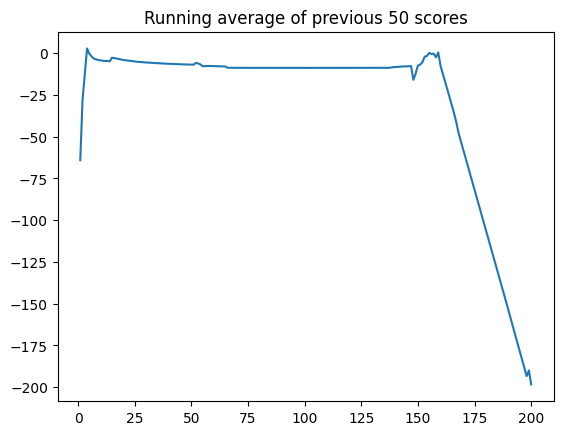

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-50):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 50 scores')
    plt.savefig(figure_file)

if __name__ == '__main__':
    env = StockTradingEnv(df_train)
    N = 20
    batch_size = 5
    n_epochs = 3
    alpha = 0.0003
    agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, 
                  alpha=alpha, n_epochs=n_epochs, 
                  input_dims=env.observation_space.shape)

    n_games = 200
    figure_file = 'stock_training.png'

    best_score = env.reward_range[0]
    score_history = []

    learn_iters = 0
    avg_score = 0
    n_steps = 0
    
    print("... starting ...")
    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        while not done:
            action, prob, val = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            n_steps += 1
            score += reward
            agent.remember(observation, action, prob, val, reward, done)
            if n_steps % N == 0:
                agent.learn()
                learn_iters += 1
            observation = observation_
            
        # Save history
        score_history.append(score)
        avg_score = np.mean(score_history[-50:])
        
        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()
        
        print(f"episode: {i}, score: {score:.2f}, avg score: {avg_score:.2f}, "
              f"best score: {best_score:.2f}, learning steps: {learn_iters}")
            
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, figure_file)

# # After training, you can add code to test the trained agent if desired
# # For example:
# print("\nTesting the trained agent:")
# test_episodes = 5
# for episode in range(test_episodes):
#     observation = env.reset()
#     done = False
#     episode_score = 0
#     while not done:
#         action, _, _ = agent.choose_action(observation)
#         observation_, reward, done, _ = env.step(action)
#         episode_score += reward
#         observation = observation_
#     print(f"Test Episode {episode + 1}: Score = {episode_score:.2f}")

# print(f"\nTraining complete. Learning curve saved to {figure_file}")

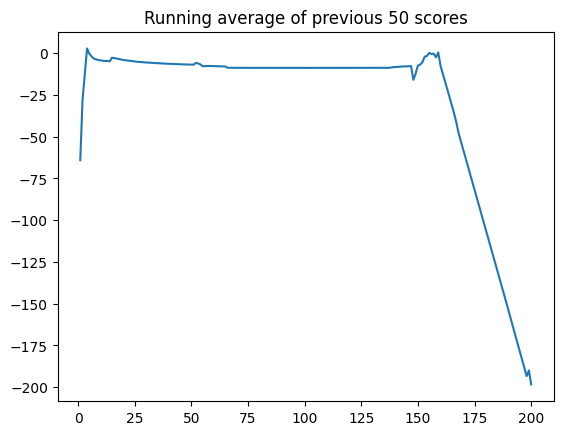

In [16]:
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, figure_file)

"""
Enhanced Stock Trading PPO Training Explanation:

1. Metrics Tracked:
   - Episode Return: The profit/loss for each trading episode.
   - Average Return: A moving average of the last 50 episodes' returns.
   - Portfolio Value: The total value of the portfolio at the end of each episode.
   - Number of Trades: How many trades were made in each episode.
   - Sharpe Ratio: A measure of risk-adjusted return for each episode.
   - Market Regime: A simple categorization of the market condition (Bull/Bear/Sideways).

2. Model Saving:
   The model is now saved based on the best Sharpe ratio achieved, rather than just the highest return.
   This encourages strategies that balance return and risk.

3. Detailed Logging:
   Every 50 episodes, a detailed metrics report is printed, including average portfolio value,
   average trades per episode, average Sharpe ratio, and maximum drawdown.

4. Learning Curve:
   The plot now shows both the raw episode returns and the moving average, providing a clearer
   picture of the agent's learning progress.

5. Final Report:
   A comprehensive performance report is generated at the end of training, summarizing key metrics.

Key Considerations for Stock Trading:

1. Risk-Adjusted Returns: By using the Sharpe ratio, we're considering not just raw returns but 
   also the risk taken to achieve those returns.

2. Trading Frequency: Tracking the number of trades helps identify if the agent is over-trading,
   which could be detrimental due to transaction costs in real-world scenarios.

3. Drawdown: Maximum drawdown is a crucial risk metric in trading, indicating the largest peak-to-trough
   decline in portfolio value.

4. Market Regimes: Categorizing episodes into different market regimes can help understand how the 
   agent performs under varying market conditions.

5. Portfolio Value: Tracking the overall portfolio value provides a clear picture of the agent's 
   performance in terms of wealth accumulation.

Remember:
- Strong performance in simulated training doesn't guarantee real-world success.
- The simplicity of the market regime categorization might not capture all nuances of real markets.
- Transaction costs, slippage, and other real-world factors should be carefully considered before 
  any live trading implementation.
- Continual monitoring and retraining may be necessary to adapt to changing market conditions.
"""

the graph shows a significant drop in performance early on and then levels off. This could indicate several things:

Initial Instability: The agent might be experiencing significant losses early in the training, possibly due to poor initial policy actions that lead to bad decisions. This is common in reinforcement learning where the agent initially explores the environment.

Convergence to Suboptimal Policy: The plot flattening out suggests that the agent might have converged to a suboptimal policy that doesn't improve further over time. This could be due to a lack of sufficient exploration or inadequate learning parameters.

Reward Structure: There might be an issue with how rewards are structured or calculated in the environment, leading to poor performance or ineffective learning signals for the agent.

Steps to Diagnose and Improve:
Review Reward Calculation: Check how rewards are being calculated within your environment. Make sure that they appropriately reflect the objectives and provide meaningful feedback for good and bad actions.

Adjust Learning Parameters:

Learning Rate (Alpha): Sometimes adjusting the learning rate can help. A lower rate might slow down learning but can lead to more stable convergence.
Exploration Techniques: Implement or adjust exploration methods like epsilon-greedy, where the exploration factor is gradually decreased, or add an entropy component to the loss to encourage exploration.
Add Debugging Outputs: Increase the verbosity of your training process outputs to include more detailed information about actions taken, rewards received, and the internal state of the agent. This can help identify what leads to the drop in performance.

Plot More Metrics: Besides the average score, plot other metrics such as loss per epoch, the variance of rewards, or specific actions chosen frequency. These can give deeper insights into what the agent is learning or failing to learn.

Experiment with Batch Size and Update Frequency: Sometimes, adjusting the batch size and how frequently the network is updated (the N parameter) can significantly impact performance.

Normalization and Scaling: Ensure that the input features to the network (observations from the environment) are normalized or scaled appropriately. Large discrepancies in feature scales can adversely affect neural network performance.

Early Stopping and Checkpoints: Implement early stopping to halt training if the performance consistently degrades over a certain number of episodes, and use model checkpointing to revert to the best model state observed.



### Load Model

In [17]:
# agent.save_models()  # This line, if uncommented, would save the model's state to disk.

n_actions = env.action_space.n  # Extract the number of actions from the environment's action space.
input_dims = env.observation_space.shape  # Extract the input dimensions from the environment's observation space.
alpha = 0.0003  # Learning rate.

# Create an instance of the ActorNetwork with the specified parameters.
model = ActorNetwork(n_actions, input_dims, alpha)

# Load the model weights from a saved state.
model.load_state_dict(T.load("tmp/actor_torch_ppo"))

# Set the model to evaluation mode.
model.eval()


ActorNetwork(
  (actor): Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
    (5): Softmax(dim=-1)
  )
)

### Get Results 

In [18]:
df_test.head(2)

index,High,Low,Open,Close,Volume,VWAP,Close_Price
i64,f64,f64,f64,f64,f64,f64,f64
700,0.071404,0.244701,0.320983,0.054813,-0.120475,0.322225,64.375
701,0.01255,0.03608,-0.011188,-0.011993,-0.086116,0.275268,64.282501


In [19]:
reporting_df = df_test.clone()
long_probs = []
short_probs = []
is_long = 1
is_short = 1
long_ratio = 0.5

# Loop through the DataFrame starting from index 5
for step in range(5, len(reporting_df)):
    # Extract required items using Polars' efficient data access methods
    # Since Polars does not support df.loc[step, "Column"], use direct row indexing if applicable or convert to pandas temporarily if direct access is required
    row = reporting_df.slice(step, 1).to_pandas().iloc[0]  # Converting slice of Polars DF to pandas for familiar access

    item_0_T0 = row["Open"]
    item_1_T0 = row["High"]
    item_2_T0 = row["Low"]
    item_3_T0 = row["Close"]
    item_4_T0 = row["Volume"]
    item_5_T0 = row["VWAP"]
    
    # Create observation array
    obs = np.array([item_0_T0, item_1_T0, item_2_T0, item_3_T0, item_4_T0, item_5_T0, long_ratio])
    
    # Convert observation to tensor, ensuring it has the correct shape (1, -1 for batch dimension)
    state = T.tensor([obs], dtype=T.float32).to(model.device)
    
    # Get the distribution from the model
    dist = model(state)
    action = dist.sample().item()  # Sampling an action from the distribution
    probs = dist.probs.detach().cpu().numpy()  # Detach probabilities and move to CPU

    print(action, probs[0])  # Print the chosen action and its probabilities
    
    # Update counts based on the chosen action
    if action == 0:
        is_long += 1
    elif action == 1:
        is_short += 1

    # Update the long ratio
    long_ratio = is_long / (is_long + is_short)

    # Store the probabilities
    long_probs.append(probs[0, 0])  # Assuming the first action corresponds to "long"
    short_probs.append(probs[0, 1])  # Assuming the second action corresponds to "short"


1 [0.20413542 0.79586464]
0 [0.22823502 0.771765  ]
1 [0.20616719 0.7938328 ]
1 [0.21650794 0.7834921 ]
0 [0.23161614 0.76838386]
1 [0.20180625 0.7981938 ]
1 [0.21295832 0.78704166]
1 [0.264295   0.73570496]
1 [0.24879304 0.751207  ]
1 [0.23189463 0.7681054 ]
0 [0.2535092  0.74649084]
1 [0.25260013 0.74739987]
1 [0.22228679 0.77771324]
1 [0.23782577 0.76217425]
0 [0.34576064 0.6542394 ]
1 [0.36086383 0.63913614]
1 [0.22276548 0.7772345 ]
1 [0.24716194 0.7528381 ]
1 [0.24985842 0.75014156]
0 [0.2807153 0.7192848]
1 [0.23663896 0.76336104]
0 [0.23804426 0.76195574]
0 [0.2812863 0.7187137]
1 [0.22169097 0.77830905]
1 [0.21351007 0.7864899 ]
0 [0.22898327 0.7710167 ]
1 [0.23769514 0.76230484]
1 [0.23450233 0.7654977 ]
1 [0.33568513 0.66431487]
1 [0.20575704 0.794243  ]
1 [0.21867587 0.78132415]
0 [0.26715228 0.7328477 ]
0 [0.24292621 0.7570738 ]
1 [0.2367376 0.7632624]
1 [0.21568443 0.7843156 ]
1 [0.22162549 0.77837455]
0 [0.23585656 0.76414347]
1 [0.23318294 0.76681703]
1 [0.2259337 0.774

In [20]:
import polars as pl

# Initial capital and investment percentage
capital = 1
perc_invest = 1

# Prepare the dataframe
df_res = reporting_df.select(["Open", "Close_Price"])
df_res = df_res.with_columns(
    (df_res["Close_Price"] / df_res["Close_Price"].shift(1) - 1).alias("Returns")
).filter(pl.col("Returns").is_not_null())

# Initialize the long and short probability lists based on your model output or trading strategy
long_probs = []
short_probs = []

# Assume this is the way you populate these lists (modify according to your actual model application)
for step in range(len(df_res)):
    # Example logic to generate long and short probabilities
    # Replace this logic with your actual model's prediction mechanism
    long_probs.append(0.6)  # Dummy probability value for long position
    short_probs.append(0.4)  # Dummy probability value for short position

# Add long and short probabilities to the DataFrame
df_res = df_res.with_columns([
    pl.Series("Longs", long_probs),
    pl.Series("Shorts", short_probs)
])

# Determine the trading direction based on long probabilities
df_res = df_res.with_columns(
    pl.when(pl.col("Longs") >= 0.5).then(pl.col("Longs")).otherwise(-pl.col("Shorts")).alias("DIR")
)

# Initialize equity and calculate cumulative returns
equities = [capital]
for i in range(1, len(df_res)):
    dir_value = df_res[i-1, "DIR"]
    ret_value = df_res[i, "Returns"]
    equity = equities[-1] + equities[-1] * perc_invest * dir_value * ret_value
    equities.append(equity)

# Append equity curve to the DataFrame
df_res = df_res.with_columns(pl.Series("Equity", equities))

# Calculate and append a benchmark curve
df_res = df_res.with_columns(
    (df_res["Returns"].cumsum() + 1).alias("Benchmark")
)

# Display the first few rows and the full DataFrame (for verification)
print(df_res.head())
print(df_res)


shape: (5, 8)
┌───────────┬─────────────┬───────────┬───────┬────────┬─────┬──────────┬───────────┐
│ Open      ┆ Close_Price ┆ Returns   ┆ Longs ┆ Shorts ┆ DIR ┆ Equity   ┆ Benchmark │
│ ---       ┆ ---         ┆ ---       ┆ ---   ┆ ---    ┆ --- ┆ ---      ┆ ---       │
│ f64       ┆ f64         ┆ f64       ┆ f64   ┆ f64    ┆ f64 ┆ f64      ┆ f64       │
╞═══════════╪═════════════╪═══════════╪═══════╪════════╪═════╪══════════╪═══════════╡
│ -0.011188 ┆ 64.282501   ┆ -0.001437 ┆ 0.6   ┆ 0.4    ┆ 0.6 ┆ 1.0      ┆ 0.998563  │
│ -0.0112   ┆ 64.309998   ┆ 0.000428  ┆ 0.6   ┆ 0.4    ┆ 0.6 ┆ 1.000257 ┆ 0.998991  │
│ 0.078887  ┆ 64.857498   ┆ 0.008513  ┆ 0.6   ┆ 0.4    ┆ 0.6 ┆ 1.005366 ┆ 1.007504  │
│ -0.001986 ┆ 65.035004   ┆ 0.002737  ┆ 0.6   ┆ 0.4    ┆ 0.6 ┆ 1.007017 ┆ 1.010241  │
│ -0.015502 ┆ 65.550003   ┆ 0.007919  ┆ 0.6   ┆ 0.4    ┆ 0.6 ┆ 1.011802 ┆ 1.01816   │
└───────────┴─────────────┴───────────┴───────┴────────┴─────┴──────────┴───────────┘
shape: (647, 8)
┌───────────┬───────────

/var/folders/4w/6x3yk1r13xvcwchd72ftlnsc0000gn/T/ipykernel_45562/881359208.py:48: DeprecationWarning: `cumsum` is deprecated. It has been renamed to `cum_sum`.
  (df_res["Returns"].cumsum() + 1).alias("Benchmark")


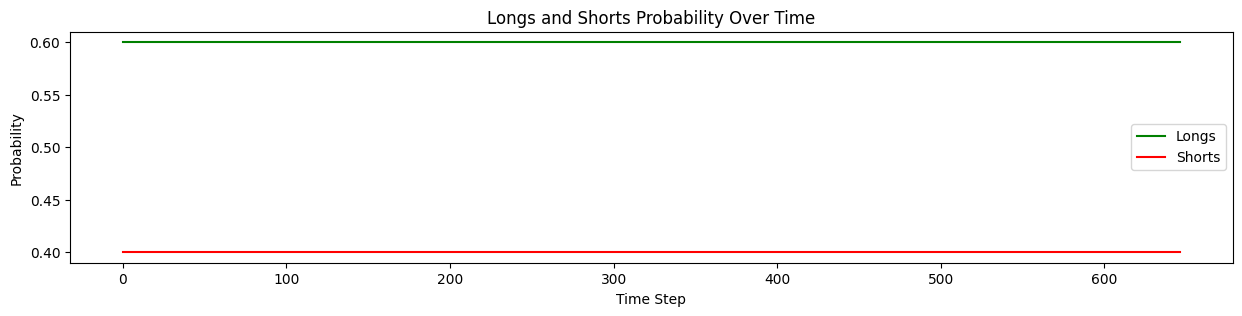

In [21]:
import matplotlib.pyplot as plt

# Set the figure size for the plot
plt.rcParams["figure.figsize"] = (15, 3)

# Convert Polars DataFrame columns to NumPy arrays for plotting
longs = df_res["Longs"].to_numpy()
shorts = df_res["Shorts"].to_numpy()

# Create a plot for Longs
plt.plot(longs, color="green", label="Longs")

# Create a plot for Shorts
plt.plot(shorts, color="red", label="Shorts")

# Add legend and labels
plt.title("Longs and Shorts Probability Over Time")
plt.xlabel("Time Step")
plt.ylabel("Probability")
plt.legend()

# Display the plot
plt.show()


In [22]:
print("Long Probabilities Sample:", long_probs[:100])
print("Short Probabilities Sample:", short_probs[:100])


Long Probabilities Sample: [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6]
Short Probabilities Sample: [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4

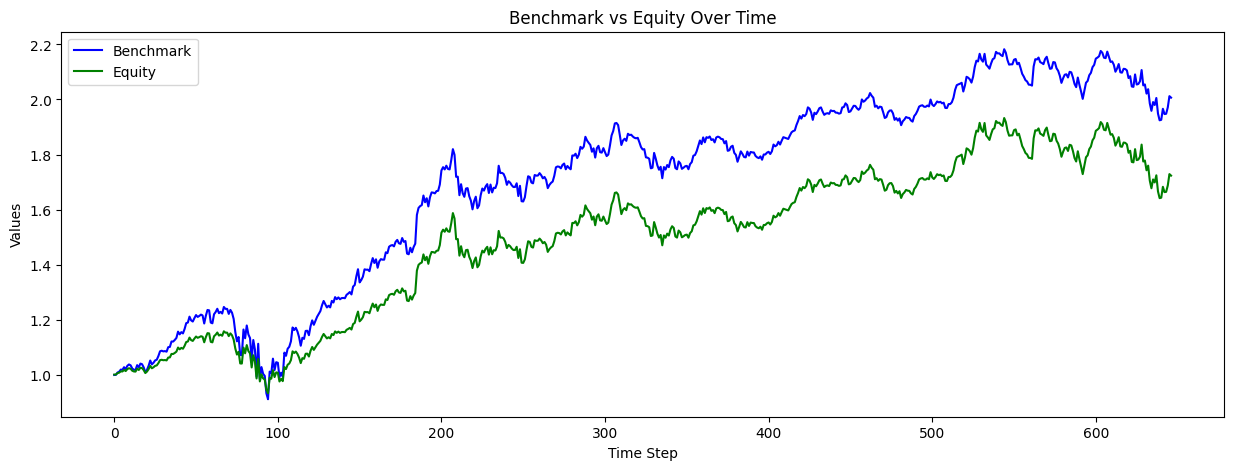

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Set the figure size for the plot
plt.rcParams["figure.figsize"] = (15, 5)

# Convert columns to NumPy arrays
benchmark = df_res["Benchmark"].to_numpy()
equity = df_res["Equity"].to_numpy()
indices = np.arange(len(benchmark))  # Assuming you want to use a simple index for the x-axis

# Plotting directly with Matplotlib
plt.plot(indices, benchmark, label='Benchmark', color='blue')
plt.plot(indices, equity, label='Equity', color='green')

# Add titles and labels
plt.title('Benchmark vs Equity Over Time')
plt.xlabel('Time Step')
plt.ylabel('Values')
plt.legend()

# Show the plot
plt.show()


In [24]:
import polars as pl

# Calculate Benchmark Return as the percentage change from the first to the last 'Close_Price'
Benchmark_Perc = ((df_res["Close_Price"][-1] / df_res["Close_Price"][0]) - 1) * 100

# Calculate ROI as the percentage change from the initial capital to the last 'Equity' value
ROI_Perc = ((df_res["Equity"][-1] / capital) - 1) * 100

# Print the calculated metrics
print(f"Benchmark Return {round(Benchmark_Perc, 2)}%")
print(f"ROI at {round(ROI_Perc, 2)}%")


Benchmark Return 131.54%
ROI at 72.33%


In [25]:
import matplotlib.pyplot as plt

# Assuming df_res is a Pandas DataFrame or has been converted to Pandas from Polars for ease of use
plt.figure(figsize=(15, 5))

# Plot the 'Benchmark' and 'Equity' columns
plt.plot(df_res.index, df_res['Benchmark'], label='Benchmark', color='blue')
plt.plot(df_res.index, df_res['Equity'], label='Equity', color='green')

plt.title('Comparison of Equity and Benchmark')
plt.xlabel('Index')
plt.ylabel('Performance Value')
plt.legend()
plt.grid(True)
plt.show()


AttributeError: 'DataFrame' object has no attribute 'index'

<Figure size 1500x500 with 0 Axes>

In [26]:
import numpy as np

# Calculate CAGR using Polars
def calculate_cagr(final_value, initial_value, periods):
    return ((final_value / initial_value) ** (1 / periods) - 1) * 100

equity_cagr = calculate_cagr(df_res['Equity'][-1], df_res['Equity'][0], len(df_res) / 252)


def calculate_max_drawdown(equity):
    # Convert equity to numpy for manipulation
    equity = equity.to_numpy()
    cumulative = np.maximum.accumulate(equity)
    drawdown = (cumulative - equity) / cumulative
    return np.max(drawdown) * 100

equity_mdd = calculate_max_drawdown(df_res['Equity'])


# Calculate Maximum Drawdown for Equity
equity_mdd = calculate_max_drawdown(df_res['Equity'])

print(f'Equity CAGR: {equity_cagr:.2f}%')
print(f'Equity Maximum Drawdown: {equity_mdd:.2f}%')



Equity CAGR: 23.61%
Equity Maximum Drawdown: 19.44%


In [ ]:
df_res


##### PPO Code adapted from https://www.youtube.com/watch?v=hlv79rcHws0 (Machine Learning with Phil)